In [1]:
%config Completer.use_jedi = False

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp , routing_parameters_pb2
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from Route_Optimizer import RouteOptimizer
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK10_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [3]:
station_coordinates

,Unnamed: 0,City Name,lat,long
0,0,Kingston_upon_Hull,53.743572,-0.339476
1,1,Pocklington,53.931568,-0.776104
2,2,Brough,54.526633,-2.317983
3,3,Selby,53.784012,-1.068781
4,4,Boughton,52.590018,0.508102
5,5,Barton_upon_Humber,53.673573,-0.442710
6,6,Darfield,53.535299,-1.376248
7,7,Bentley,51.989667,1.075096
8,8,Watton,52.569918,0.825349
9,9,Cudworth,53.573384,-1.419644


In [4]:
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)
distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

In [5]:
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)
# from scipy.spatial.distance import squareform 
# from scipy.spatial.distance import pdist
# distance_matrix_here = squareform(pdist(points_coordinate))

In [6]:
distance_matrix_here

,0,1,2,3,4,5,6,7,8,9,10
0,0,45436,207112,60243,339336,18881,97620,355274,336346,94662,70883
1,41374,0,162009,40816,344110,43528,94453,360048,341120,90520,28043
2,206972,165053,0,145180,427976,205415,170963,443914,424986,165338,124482
3,60069,39266,145518,0,306560,58295,53849,322498,303570,49916,34495
4,195906,234807,357809,220004,0,179511,226886,90070,31561,235817,255397
5,18498,44261,205937,59068,193895,0,90488,348142,228923,93487,69708
6,97304,94312,169037,50943,283088,93308,0,299026,280098,9101,81099
7,356334,360810,444568,329430,90529,354777,318508,0,84501,312883,356630
8,337503,351012,425737,307643,31638,330205,280789,83971,0,289720,337799
9,94723,90085,164810,46716,294703,93166,8859,310641,291713,0,76872


## Construct data model parameters

In [7]:

starts=[0,6]

ends = [2,4]#np.zeros(len(starts),dtype=int).tolist()

vehicle_amount = len(starts)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
customer_demands[ends] = 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]

distance_matrix = distance_matrix_here
#distance_matrix = make_open_problem(distance_matrix_here,ends)

#distance_matrix = make_open_problem(squareform(pdist(points_coordinate)),starts)

#depot = 0


data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
                   'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'startpoints':starts,'endpoints':ends}



# data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
#                    'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'depot':depot}


## Create data model

In [8]:
data = create_data_model_start_endpoints(**data_model_input)

In [9]:
pd.DataFrame(data['distance_matrix'])

,0,1,2,3,4,5,6,7,8,9,10
0,0,45436,207112,60243,339336,18881,97620,355274,336346,94662,70883
1,41374,0,162009,40816,344110,43528,94453,360048,341120,90520,28043
2,206972,165053,0,145180,427976,205415,170963,443914,424986,165338,124482
3,60069,39266,145518,0,306560,58295,53849,322498,303570,49916,34495
4,195906,234807,357809,220004,0,179511,226886,90070,31561,235817,255397
5,18498,44261,205937,59068,193895,0,90488,348142,228923,93487,69708
6,97304,94312,169037,50943,283088,93308,0,299026,280098,9101,81099
7,356334,360810,444568,329430,90529,354777,318508,0,84501,312883,356630
8,337503,351012,425737,307643,31638,330205,280789,83971,0,289720,337799
9,94723,90085,164810,46716,294703,93166,8859,310641,291713,0,76872


## Construct Simulated Annealing class

In [38]:
class Optimizer_SA(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.solution_limit = 50
        search_parameters.time_limit.seconds = 30
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_ARC)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
        return search_parameters

In [39]:
class Optimizer_TABU(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.time_limit.seconds = 30
        search_parameters.solution_limit = 50
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_ARC)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
        return search_parameters

In [40]:
class Optimizer_GLS(RouteOptimizer):
    
    def __init__(self,data={}):
        super().__init__(data)
        
    def init_search_parameters(self):
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.log_search = True
        search_parameters.solution_limit = 50
        search_parameters.time_limit.seconds = 30
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_ARC)
        search_parameters.local_search_metaheuristic =(routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        return search_parameters

## Set up constraints

In [41]:

def demand_callback(from_index):
    if from_index in ends:
        return 0
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def fuel_consumption_callback(from_index, to_index):
    if from_index in ends:
        return 0
    """Returns the estimated fuel consumption between two nodes.
    Based on 'A Fuel Consumption Objective of VRP and the Genetic Algorithm' by Hao Xiong"""
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    #Distance in 100km
    distance = (data['distance_matrix'][from_node][to_node])/1e5
    #Demand in kg
    demand = data['demands'][from_node]
    #Fuel consumption between nodes driving empty vehicle
    fuel_consumption_empty = distance * meta_data['F-C Empty (l/100km)']
    load_rate = demand / float(meta_data['Max Load(kg)'])
    #Additional fuel consumption when adding load at from_index
    fuel_consumption_load = distance * load_rate * (meta_data['F-C Full (l/100km)'] - meta_data['F-C Empty (l/100km)'])
    return np.float(fuel_consumption_empty + fuel_consumption_load)
    
    


In [95]:
def fuel_consumption_rakha(from_index,to_index,distance_matrix=distance_matrix,time_matrix=time_matrix_here,demands=data['demands'],vehicle_weight=3000):
    """
    Returns the estimated fuel consumption between two nodes.
    Assumes an acceleration and road gradient of 0
    Based on 'Virginia Tech Comprehensive Power-Based Fuel Consumption Model:Model development and testing' by Rakha et al. (2011) 
    Rakha et al. mentiones the follwing source:
    https://books.google.se/books?hl=sv&lr=&id=Blp2D1DteTYC&oi=fnd&pg=PR11&dq=Theory+of+Ground+Vehicles+J.Y.+Wong&ots=Xump_f09hf&sig=SMj4XXTZlJYlep9qNLTltx4zFHg&redir_esc=y
    """
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    if from_node == to_node:
        return 0
    
    function_data = get_fuel_data_rakha()
    
    distance = distance_matrix.iloc[from_node][to_node]
    
    demand = demands[from_node]
    
    current_speed = distance/time_matrix.iloc[from_node][to_node]
    specific_fuel_consumption = function_data["diesel_density"] * (meta_data["F-C Empty (l/100km)"]/1e5)*current_speed/function_data["engine_breaking_effect"]
    
    current_speed_km_h = current_speed * 3.6
    curb_weight =  demand + vehicle_weight
    g = 9.8066
    R = (function_data["air_density"]/25.92) * function_data["drag"] * function_data["frontal_area"] * current_speed_km_h**2 + \
        g * curb_weight * (function_data["rolling_coeff"]/1000) * (function_data["c1"] * current_speed_km_h + function_data["c2"])
    
    P = R/(3600*0.45) * current_speed_km_h
    
    F = specific_fuel_consumption * (((function_data["engine_internal_friction"] * function_data["no_revolution"] * function_data["engine_displacement"])/2000) + P)
    
    fuel_consumption  = F*time_matrix.iloc[from_node][to_node]

    
    return np.float(fuel_consumption)

## Add constraints and weights. This should be turned in to functions in the future

In [97]:

# Create the routing index manager.
manager = create_routing_index_manager(data)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)
# ========== Add capacity cost & constraint to routing model ==========
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
dimension_name = 'Capacity'
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    dimension_name)
demand_dimension = routing.GetDimensionOrDie(dimension_name)
demand_dimension.SetGlobalSpanCostCoefficient(0)

# =====================================================================

# # ========== Add distance cost & constraint to routing model ==========
# transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# # Add Distance constraint.
# dimension_name = 'Distance'
# routing.AddDimension(
#     transit_callback_index,
#     0,  # no slack
#     250000000,  # vehicle maximum travel distance
#     True,  # start cumul to zero
#     dimension_name)
# distance_dimension = routing.GetDimensionOrDie(dimension_name)
# # Set distance weight to a high number since using coordinates
# distance_dimension.SetGlobalSpanCostCoefficient(0)
# # =====================================================================

# ========== Add fuel consumption cost & constraint to routing model ==========
fuel_callback_index = routing.RegisterTransitCallback(fuel_consumption_rakha)
# Add Distance constraint.
dimension_name = 'Fuel Consumption'
routing.AddDimension(
    fuel_callback_index,
    0,  # no slack
    100000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
fuel_dimension = routing.GetDimensionOrDie(dimension_name)
# Set distance weight to a high number since using coordinates
fuel_dimension.SetGlobalSpanCostCoefficient(1)
# =====================================================================

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(fuel_callback_index)
# Create callback object for storing cost values
callback = Callback(routing)

In [98]:
# Add the data, manager, routing and callback to the optimizer
optimizerSA = Optimizer_TABU(data)
optimizerSA.set_manager(manager)
optimizerSA.set_routing(routing)
optimizerSA.set_solution_callback(callback)

In [99]:
#https://github.com/google/or-tools/discussions/2263
# Initiate a solution collector for the optimizer
collector = optimizerSA.routing.solver().AllSolutionCollector()
# #Create a IntVar for each node in the matrix and add to collector
for order_node in range(len(data["distance_matrix"])):
#     # Extract each node index from manager
    index = manager.NodeToIndex(order_node)
    if index != -1:
        # Gets an IntVar object representing the next node after each node in the data set
        next_var = optimizerSA.routing.NextVar(index)
        # Adds the IntVar to the collector. This tells the 
        # Collector that it should watch the value of this IntVar
        # Since the collector is of type "AllSolutionCollector",
        # These values will be stored each time a solution is found.
        collector.Add(next_var)

# Add Collector to optimizer routing
optimizerSA.routing.AddSearchMonitor(collector)



## Solve problem

In [100]:
start_time = datetime.now()

optimizerSA.solve_with_parameters()
solutions = extract_all_solutions(collector)

In [101]:
# fuel_consumptions_SA = calulate_search_costs(solutions,fuel_consumption_callback,starts)
# distances_SA = calulate_search_costs(solutions,distance_callback,starts)
# searchTimes_SA = list(map(lambda x: (x - start_time).total_seconds(),callback.solutionTimes))
print("Amount of solutions found during search: {}".format(collector.SolutionCount()))

Amount of solutions found during search: 20


In [102]:
get_results(optimizerSA.get_routes([0,6]),data_model_input['distance_matrix'],station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,207.112,0,25.889000,1.25000,20.971077,1.012548,85.810013,8689,02:24:49.00
1,567.974,4546,81.353172,1.43234,52.520037,0.924691,57.471089,35578,09:52:58.00


In [49]:
# fig, ax = plt.subplots(1, 2,figsize=(20,10))
# import math

# y1 = [math.log10(num) for num in searchTimes_GLS]
# y2 = [math.log10(num) for num in searchTimes_TABU]
# y3 = [math.log10(num) for num in searchTimes_SA]



# ax[0].plot(fuel_consumptions_GLS.sum(axis=1),label="GLS",linestyle="--")
# ax[0].plot(fuel_consumptions_TABU.sum(axis=1),label="TABU")
# ax[0].plot(fuel_consumptions_SA.sum(axis=1),label="SA",linestyle="-.")
# ax[0].legend()
# ax[0].set_xticks(range(20))
# ax[0].set_xlabel("Epoch",fontsize=16)
# ax[0].set_ylabel("Fuel consumption (L)",fontsize=16)

# ax[1].plot(y1,label="GLS",linestyle="--")
# ax[1].plot(y2,label="TABU")
# ax[1].plot(y3,label="SA",linestyle="-.")
# ax[1].legend()
# ax[1].set_xticks(range(20))
# ax[1].set_xlabel("Epoch",fontsize=16)
# ax[1].set_ylabel("Runtime $Log_{10}$ (S)",fontsize=16)

# #plt.plot(fuel_consumptions_GLS,linestyle="--")
# plt.show()

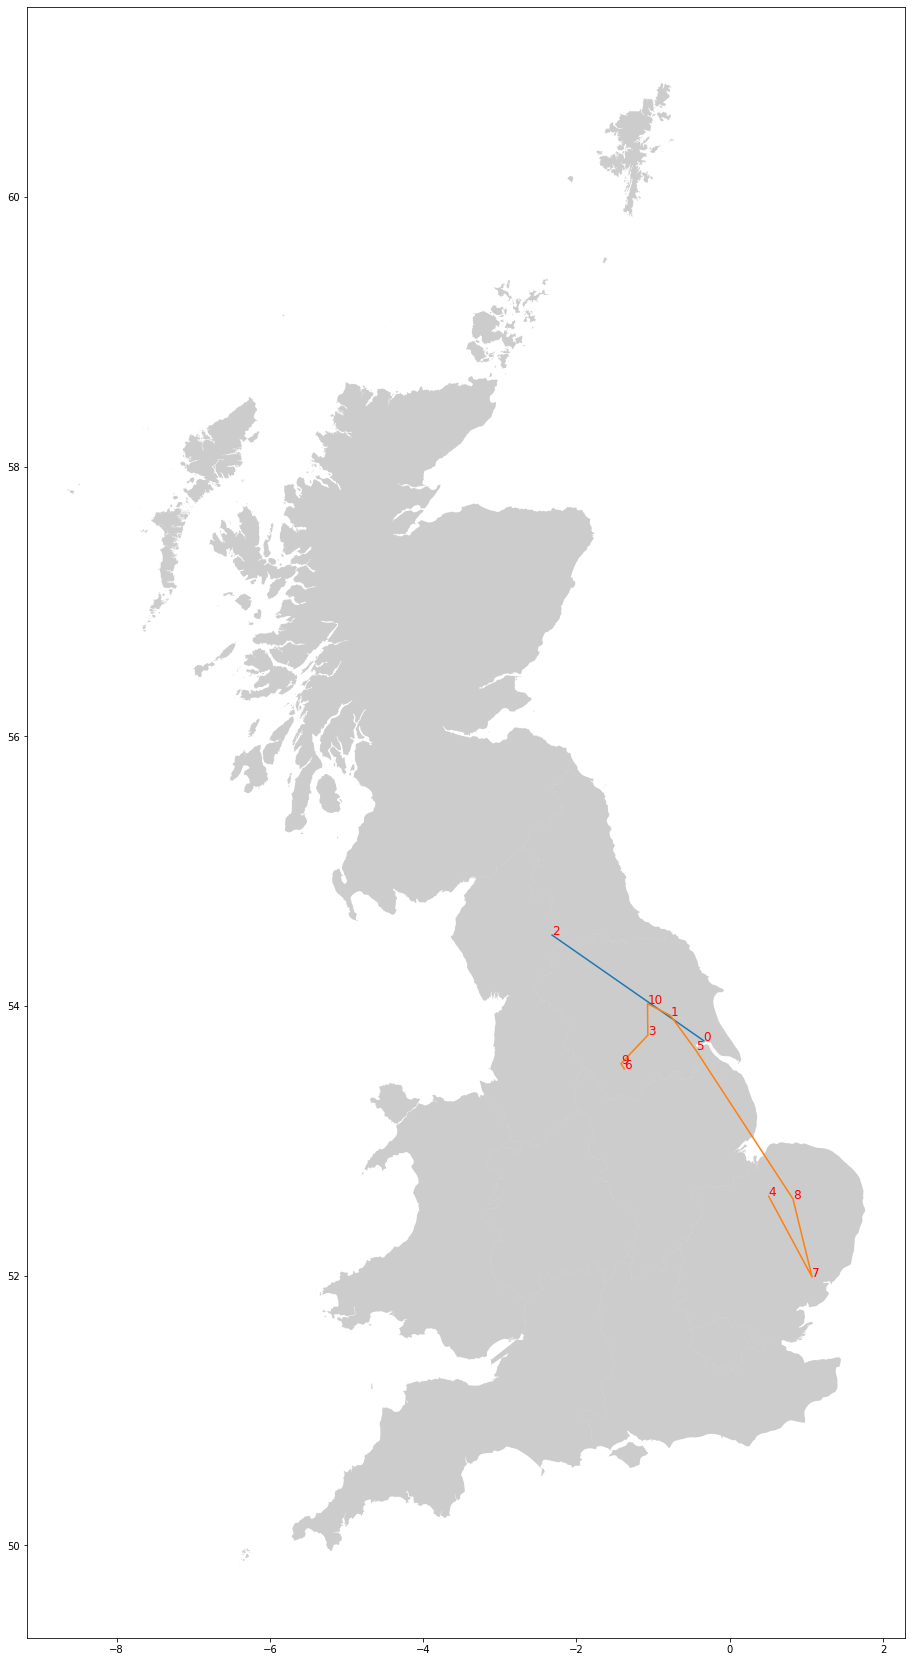

In [103]:
plot_routes(optimizerSA.get_routes(),points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

## Plot generated routes on map

In [47]:
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in optimizerSA.get_routes():
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


In [48]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
m_1 = folium.Map(location=points_coordinate[0], tiles='openstreetmap', zoom_start=8)
MarkerCluster(points_coordinate).add_to(m_1)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
for route,color in zip(vehicle_routes,colors[:len(vehicle_routes)]):
    if(len(route) > 1):
        folium.PolyLine(route,color=color).add_to(m_1)
    
# Display the map
m_1